In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.results import Results
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from ephysvibe.spike_sorting import config
from ephysvibe.task import task_constants
from ephysvibe.task.task_constants import EVENTS_B1_SHORT
from ephysvibe.trials.spikes import firing_rate, sp_constants
import plot_trials

In [15]:
def select_trials_by_percentile(x: np.ndarray, mask: np.ndarray = None):
    ntr = x.shape[0]
    if mask is None:
        mask = np.full(ntr, True)

    mntr = x[mask].shape[0]

    if mntr < 2:
        return np.full(ntr, True)
    mean_trs = np.mean(x, axis=1)

    q25, q75 = np.percentile(mean_trs[mask], [25, 75])
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr
    lower_limit = q25 - 1.5 * iqr

    q1mask = mean_trs > lower_limit
    q2mask = mean_trs < upper_limit

    qmask = np.logical_and(q1mask, q2mask)
    return qmask

In [16]:
def prepare_data_plotb1(
    neu,
    rf_stim_loc: list = ["contra", "ipsi"],
    percentile: bool = False,
    cerotr: bool = False,
):
    samples = [0, 11, 15, 55, 51]
    # IN
    sp_sampleon_0, mask_sampleon_0 = neu.align_on(
        select_block=1,
        event="sample_on",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[0],
    )
    samples_sampleon_0 = select_trials.get_sp_by_sample(
        sp_sampleon_0, neu.sample_id[mask_sampleon_0], samples=samples
    )
    sp_test_0, mask_test_0 = neu.align_on(
        select_block=1,
        event="test_on_1",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[0],
    )
    samples_test_0 = select_trials.get_sp_by_sample(
        sp_test_0, neu.sample_id[mask_test_0], samples=samples
    )
    # OUT
    sp_sampleon_1, mask_sampleon_1 = neu.align_on(
        select_block=1,
        event="sample_on",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[1],
    )
    samples_sampleon_1 = select_trials.get_sp_by_sample(
        sp_sampleon_1, neu.sample_id[mask_sampleon_1], samples=samples
    )
    sp_test_1, mask_test_1 = neu.align_on(
        select_block=1,
        event="test_on_1",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[1],
    )
    samples_test_1 = select_trials.get_sp_by_sample(
        sp_test_1, neu.sample_id[mask_test_1], samples=samples
    )

    # Check trials
    samplesstr = ["0", "11", "15", "55", "51"]
    if percentile or cerotr:
        for isamp in samplesstr:
            if ~np.all((np.isnan(samples_sampleon_0[isamp]))):
                temp = np.concatenate(
                    (
                        samples_sampleon_0[isamp][:, 300 : 500 + 450 + 400],
                        samples_test_0[isamp][:, 100 : 500 + 500],
                    ),
                    axis=1,
                )
                masknocero = np.full(temp.shape[0], True)
                maskper = np.full(temp.shape[0], True)
                if cerotr:
                    masknocero = np.sum(temp, axis=1) != 0
                if percentile:
                    maskper = select_trials_by_percentile(temp, masknocero)
                mask = np.logical_and(masknocero, maskper)
                if np.sum(mask) < 10:
                    mask = np.full(temp.shape[0], True)
                samples_sampleon_0[isamp] = samples_sampleon_0[isamp][mask]
                samples_test_0[isamp] = samples_test_0[isamp][mask]

                # if np.all(np.isnan(samples_sampleon_1[isamp])):
                #     samples_sampleon_1[isamp] = np.zeros((2, 1950))
                # if np.all(np.isnan(samples_test_1[isamp])):
                #     samples_test_1[isamp] = np.zeros((2, 1950))

            if ~np.all((np.isnan(samples_sampleon_1[isamp]))):
                temp = np.concatenate(
                    (
                        samples_sampleon_1[isamp][:, 300 : 500 + 450 + 400],
                        samples_test_1[isamp][:, 100 : 500 + 500],
                    ),
                    axis=1,
                )
                masknocero = np.full(temp.shape[0], True)
                maskper = np.full(temp.shape[0], True)
                if cerotr:
                    masknocero = np.sum(temp, axis=1) != 0
                if percentile:
                    maskper = select_trials_by_percentile(temp, masknocero)
                mask = np.logical_and(masknocero, maskper)
                if np.sum(mask) < 10:
                    mask = np.full(temp.shape[0], True)
                samples_sampleon_1[isamp] = samples_sampleon_1[isamp][mask]
                samples_test_1[isamp] = samples_test_1[isamp][mask]

    # Start convolution
    fs_ds = config.FS / config.DOWNSAMPLE
    kernel = firing_rate.define_kernel(
        sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
    )

    # IN
    conv_0 = {}
    samples_0 = {}
    for isamp in samples_sampleon_0.keys():
        if np.all((np.isnan(samples_sampleon_0[isamp]))):
            conv_0[isamp] = np.zeros((1, 1950))
            samples_0[isamp] = np.zeros((1, 1950))
            continue
        conv_sonin = (
            np.convolve(np.mean(samples_sampleon_0[isamp], axis=0), kernel, mode="same")
            * fs_ds
        )[300 : 500 + 450 + 400]

        conv_testin = (
            np.convolve(np.mean(samples_test_0[isamp], axis=0), kernel, mode="same")
            * fs_ds
        )[100 : 500 + 500]

        conv_0[isamp] = np.concatenate((conv_sonin, conv_testin))
        samples_0[isamp] = np.concatenate(
            (
                samples_sampleon_0[isamp][:, 300 : 500 + 450 + 400],
                samples_test_0[isamp][:, 100 : 500 + 500],
            ),
            axis=1,
        )

    # OUT
    conv_1 = {}
    samples_1 = {}
    for isamp in samples_sampleon_1.keys():

        if np.all((np.isnan(samples_sampleon_1[isamp]))):
            conv_1[isamp] = np.zeros((1, 1950))
            samples_1[isamp] = np.zeros((1, 1950))
            continue
        conv_sonin = (
            np.convolve(np.mean(samples_sampleon_1[isamp], axis=0), kernel, mode="same")
            * fs_ds
        )[300 : 500 + 450 + 400]
        conv_testin = (
            np.convolve(np.mean(samples_test_1[isamp], axis=0), kernel, mode="same")
            * fs_ds
        )[100 : 500 + 500]
        conv_1[isamp] = np.concatenate((conv_sonin, conv_testin))
        samples_1[isamp] = np.concatenate(
            (
                samples_sampleon_1[isamp][:, 300 : 500 + 450 + 400],
                samples_test_1[isamp][:, 100 : 500 + 500],
            ),
            axis=1,
        )
    sp = {rf_stim_loc[0]: samples_0, rf_stim_loc[1]: samples_1}
    conv = {rf_stim_loc[0]: conv_0, rf_stim_loc[1]: conv_1}

    return sp, conv

In [17]:
path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2023-11-29_11-06-51_Riesling_lip_e1_r1_mua3_neu.h5'
neu = NeuronData.from_python_hdf5(path)
nid = neu.get_neuron_id()

In [19]:
neu.area

'lip'

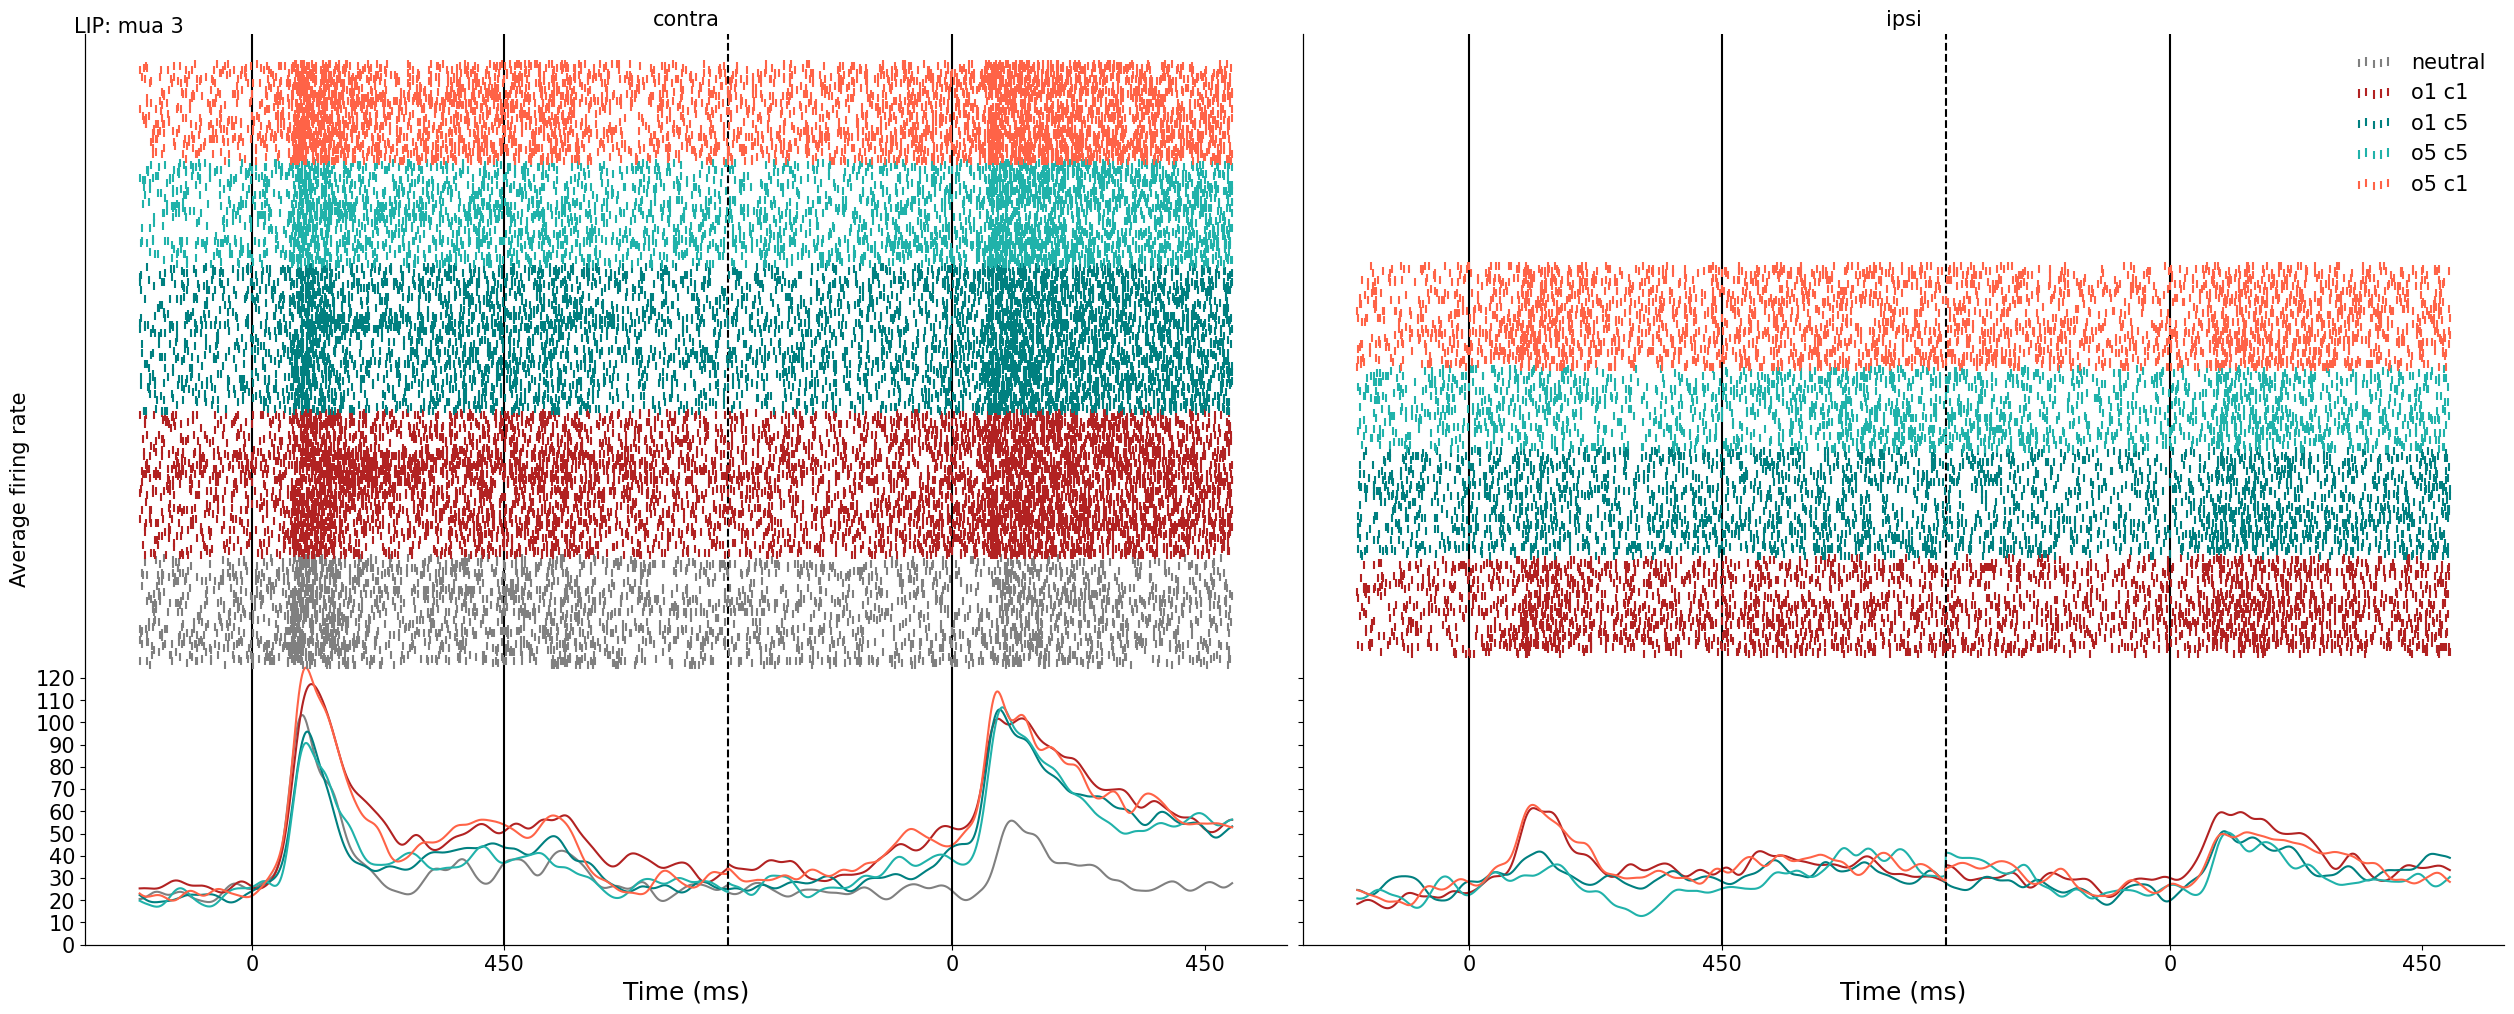

In [18]:
sp, conv = prepare_data_plotb1(neu,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=neu.plot_sp_b1(sp, conv)

In [20]:
sp['contra']['11']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
orientation1 = np.concatenate([sp['contra']['11'],sp['contra']['15']],axis=0)
o_avg1 = firing_rate.moving_average(
    orientation1, win=100, step=1
)
orientation5 = np.concatenate([sp['contra']['51'],sp['contra']['55']],axis=0)
o_avg5 = firing_rate.moving_average(
    orientation5, win=100, step=1
)

color1 = np.concatenate([sp['contra']['11'],sp['contra']['51']],axis=0)
c_avg1 = firing_rate.moving_average(
    color1, win=100, step=1
)
color5 = np.concatenate([sp['contra']['15'],sp['contra']['55']],axis=0)
c_avg5 = firing_rate.moving_average(
    color5, win=100, step=1
)

In [28]:
avg_sample_on[:,330]

array([0.08, 0.1 , 0.09, 0.09, 0.08, 0.09, 0.09, 0.09, 0.11, 0.1 , 0.06,
       0.07, 0.11, 0.09, 0.12, 0.11, 0.07, 0.09, 0.09, 0.12, 0.1 , 0.12,
       0.09, 0.09, 0.11, 0.12, 0.12, 0.11, 0.11, 0.11, 0.13, 0.12, 0.09,
       0.05, 0.12, 0.12, 0.12, 0.07, 0.17, 0.11, 0.19, 0.11, 0.16, 0.1 ,
       0.15, 0.11, 0.12, 0.12, 0.12, 0.08, 0.1 , 0.07, 0.08, 0.09, 0.09,
       0.09, 0.1 , 0.07, 0.07, 0.06, 0.1 , 0.11, 0.14, 0.09, 0.12, 0.11,
       0.07])

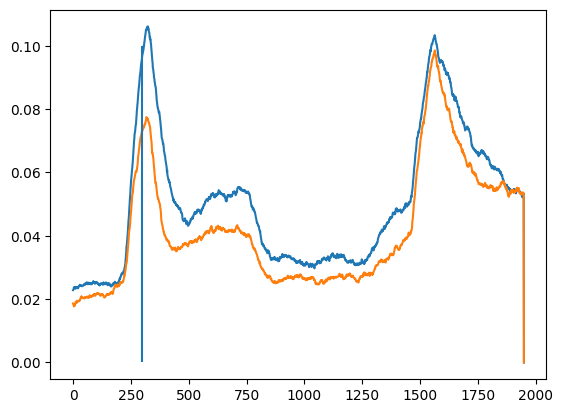

In [42]:
plt.plot(np.mean(c_avg1,axis=0))
plt.plot(np.mean(c_avg5,axis=0))
plt.vlines(300,0,0.1)

In [53]:
PALETTE_B1 = {
    "11": "firebrick",  # o1_c1
    "15": "teal",  # o1_c5
    "51": "tomato",  # o5_c1
    "55": "lightseagreen",  # o5_c5
    "0": "grey",  # o0_c0
}

(array([ 1.,  0.,  2.,  3., 10., 18., 19., 26., 14., 13.,  4.,  2.,  0.,
         0.,  1.]),
 array([ 40.        ,  49.33333333,  58.66666667,  68.        ,
         77.33333333,  86.66666667,  96.        , 105.33333333,
        114.66666667, 124.        , 133.33333333, 142.66666667,
        152.        , 161.33333333, 170.66666667, 180.        ]),
 <BarContainer object of 15 artists>)

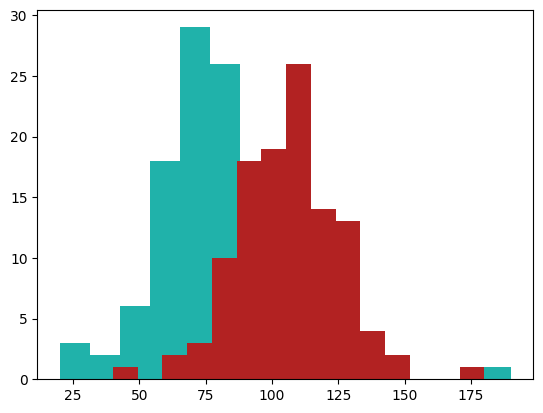

In [58]:
plt.hist(c_avg5[:,320]*1000,bins=15,color=PALETTE_B1['55'])
plt.hist(c_avg1[:,320]*1000,bins=15,color=PALETTE_B1['11'])